In [1]:
import keras
import tensorflow as tf
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from keras import optimizers
from keras.utils import np_utils
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping 
import matplotlib.pyplot as plt
import re, os, sys, platform
from collections import Counter
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
import pickle
import fileinput
from tensorflow.keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## Reading FASTA file

In [2]:
!wget https://raw.githubusercontent.com/33220311/Extremophiles/main/iThermo/PAAC.txt

--2022-07-04 02:59:05--  https://raw.githubusercontent.com/33220311/Extremophiles/main/iThermo/PAAC.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335 [text/plain]
Saving to: ‘PAAC.txt’

PAAC.txt            100%[===================>]     335  --.-KB/s    in 0s      

2022-07-04 02:59:05 (10.6 MB/s) - ‘PAAC.txt’ saved [335/335]



In [3]:
#jangan lupa rename file jadi sc.pickle saja
!wget https://github.com/33220311/Extremophiles/blob/main/iThermo/sc.pickle?raw=true

--2022-07-04 02:59:05--  https://github.com/33220311/Extremophiles/blob/main/iThermo/sc.pickle?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/33220311/Extremophiles/raw/main/iThermo/sc.pickle [following]
--2022-07-04 02:59:06--  https://github.com/33220311/Extremophiles/raw/main/iThermo/sc.pickle
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/33220311/Extremophiles/main/iThermo/sc.pickle [following]
--2022-07-04 02:59:06--  https://raw.githubusercontent.com/33220311/Extremophiles/main/iThermo/sc.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request

In [4]:
!wget https://raw.githubusercontent.com/33220311/Extremophiles/main/iThermo/non-thermophilic.fas.1

--2022-07-04 02:59:06--  https://raw.githubusercontent.com/33220311/Extremophiles/main/iThermo/non-thermophilic.fas.1
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562805 (550K) [text/plain]
Saving to: ‘non-thermophilic.fas.1’

non-thermophilic.fa 100%[===================>] 549.61K  --.-KB/s    in 0.02s   

2022-07-04 02:59:06 (31.4 MB/s) - ‘non-thermophilic.fas.1’ saved [562805/562805]



In [5]:
!wget https://raw.githubusercontent.com/33220311/Extremophiles/main/iThermo/thermophilic.fas.1

--2022-07-04 02:59:06--  https://raw.githubusercontent.com/33220311/Extremophiles/main/iThermo/thermophilic.fas.1
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 486458 (475K) [text/plain]
Saving to: ‘thermophilic.fas.1’

thermophilic.fas.1  100%[===================>] 475.06K  --.-KB/s    in 0.02s   

2022-07-04 02:59:07 (26.9 MB/s) - ‘thermophilic.fas.1’ saved [486458/486458]



In [6]:
#reading fasta sequences
with open('non-thermophilic.fas.1') as f:
    ntrecords = f.read()   
    ntrecords = ntrecords.split('>')[1:]
    myntFasta = []
    myntseq = []

In [7]:
for fasta in ntrecords:
    ntarray = fasta.split('\n')
    name, sequence = ntarray[0].split()[0], re.sub('[^ARNDCQEGHILKMFPSTWYV-]', '-', ''.join(ntarray[1:]).upper())
    kelas = 0
    myntFasta.append([name, sequence, kelas])
    myntseq.append(sequence)

In [8]:
myntFasta[0][2]

0

In [9]:
#reading fasta sequences
with open('thermophilic.fas.1') as f:
    trecords = f.read()   
    trecords = trecords.split('>')[1:]
    mytFasta = []
    mytseq = []

In [10]:
for fasta in trecords:
    tarray = fasta.split('\n')
    name, sequence = tarray[0].split()[0], re.sub('[^ARNDCQEGHILKMFPSTWYV-]', '-', ''.join(tarray[1:]).upper())
    mytFasta.append([name, sequence, 1])
    mytseq.append(sequence)

In [11]:
myFasta = mytFasta + myntFasta
myFasta[2][2]

1

In [12]:
myseq = mytseq + myntseq
len(myseq)

2809

In [13]:
#importing fasta files
#filenames = ['non-thermophilic.fas.1', 'thermophilic.fas.1']
#with open('combine.fas.1', 'w') as fasta:
#    for fname in filenames:
#        with open(fname) as infile:
#            for line in infile:
#                fasta.write(line)

In [14]:
#reading fasta sequences
#with open('combine.fas.1') as f:
#    records = f.read()   
#    records = records.split('>')[1:]
#    myFasta = []
#    myseq = []

In [15]:
#for fasta in records:
#    array = fasta.split('\n')
#    name, sequence = array[0].split()[0], re.sub('[^ARNDCQEGHILKMFPSTWYV-]', '-', ''.join(array[1:]).upper())
#    myFasta.append([name, sequence])
#    myseq.append(sequence)

In [16]:
myseq

['MALADISGYLDVLDSVRGFSYLENAREVLRSGEARCLGNPRSEPEYVKALYVIGASRIPVGDGCSHTLEELGVFDISVPGEMVFPSPLDFFERGKPTPLVRSRLQLPNGVRVWLKLEWYNPFSLSVKDRPAVEIISRLSRRVEKGSLVADATSSNFGVALSAVARLYGYRARVYLPGAAEEFGKLLPRLLGAQVIVDPEAPSTVHLLPRVMKDSKNEGFVHVNQFYNDANFEAHMRGTAREIFVQSRRGGLALRGVAGSLGTSGHMSAAAFYLQSVDPSIRAVLVQPAQGDSIPGIRRVETGMLWINMLDISYTLAEVTLEEAMEAVVEVARSDGLVIGPSGGAAVKALAKKAAEGDLEPGDYVVVVPDTGFKYLSLVQNALEGAGDSV',
 'MYTSFHRIDLPRTIVVGGGVLDKAGGYVSGVAQRGSYVLVVSGPTVSSKYFERLRASLEAEGLTVGLKIIRDATVETAEEVAREALESRIEVVAGLGGGKSIDVAKYASKRAGSVFVSIPTVASHDGITSPFSSLKGFDKPISRPAKAPEAIIIDVDVIAEAPRRYNIAGFGDLIGKYTAVLDWRLAHKLRLEYYGEYAASLALLSAKHVSQYAEEIALGTREGYRVLLEALVSSGVSMCIAGSTRPASGSEHLFAHALHIVARNKPLHGEAVGVGTIMMAYLHGKNWRRIRGLLKTVGAPTNAKELGVEDDEVVEALTIAARIRPERYTILGEKGLTREAAEALARKTGVI',
 'MPGSIPLIGERFPEMEVTTDHGVIKLPDHYVSQGKWFVLFSHPADFTPVCTTEFVSFARRYEDFQRLGVDLIGLSVDSVFSHIKWKEWIERHIGVRIPFPIIADPQGTVARRLGLLHAESATHTVRGVFIVDARGVIRTMLYYPMELGRLVDEILRIVKALKLGDSLKRAVPADWPNNEIIGEGLIVPPPTTEDQARARMESGQYRCLDWWFCWDTPASRDDVEEARRYLRRAAEKPAKLLYEEART

## AAC

In [17]:
# 1-Amino acid composition(AAC)
AA = 'ACDEFGHIKLMNPQRSTVWY'
encodings = []
header = ['#']
for i in AA:
    header.append(i)
encodings.append(header)
for i in myFasta:
    name, sequence = i[0], re.sub('-', '', i[1])
    count = Counter(sequence)
    for key in count:
        count[key] = count[key]/len(sequence)
    code = [name]
    for aa in AA:
        code.append(count[aa])
    encodings.append(code)

In [18]:
#saving extracted features
file = ('AAC.tsv')
with open(file, 'w') as f:
        for i in range(len(encodings[0]) - 1):
            f.write(encodings[0][i] + '\t')
        f.write(encodings[0][-1] + '\n')
        for i in encodings[1:]:
            f.write(i[0] + '\t')
            for j in range(1, len(i) - 1):
                f.write(str(float(i[j])) + '\t')
            f.write(str(float(i[len(i)-1])) + '\n')
tsv_file=('AAC.tsv')
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('AAC.csv',index=False)

## PAAC

In [19]:
# 2-Pseudo amino acid composition(PAAC)
pPath = os.path.split('PAAC.txt')[0]
sys.path.append(pPath)
dataFile = re.sub('codes$', '', pPath )+ r'/PAAC.txt' if platform.system() == 'Windows' else re.sub('codes$', '', pPath) + 'PAAC.txt'
dataFile

'PAAC.txt'

In [20]:
def Rvalue(aa1, aa2, AADict, Matrix):
    return sum([(Matrix[i][AADict[aa1]] - Matrix[i][AADict[aa2]]) ** 2 for i in range(len(Matrix))]) / len(Matrix)

In [21]:
lambdaValue,w = 30,0.05

In [22]:
with open(dataFile) as f:
    records = f.readlines()
AA = ''.join(records[0].rstrip().split()[1:])
AADict = {}
for i in range(len(AA)):
    AADict[AA[i]] = i
AAProperty = []
AAPropertyNames = []
for i in range(1, len(records)):
    array = records[i].rstrip().split() if records[i].rstrip() != '' else None
    AAProperty.append([float(j) for j in array[1:]])
    AAPropertyNames.append(array[0])
    AAProperty1 = []
for i in AAProperty:
    meanI = sum(i) / 20
    fenmu = math.sqrt(sum([(j-meanI)**2 for j in i])/20)
    AAProperty1.append([(j-meanI)/fenmu for j in i])
    encodings = []
header = ['#']
for aa in AA:
    header.append('Xc1.' + aa)
for n in range(1, lambdaValue + 1):
    header.append('Xc2.lambda' + str(n))
encodings.append(header)
for i in myFasta:
    name, sequence = i[0], re.sub('-', '', i[1])
    code = [name]
    theta = []
    for n in range(1, lambdaValue + 1):
        theta.append(sum([Rvalue(sequence[j], sequence[j + n], AADict, AAProperty1) for j in range(len(sequence) - n)]) / (len(sequence) - n))
    myDict = {}
    for aa in AA:
        myDict[aa] = sequence.count(aa)
    code = code + [myDict[aa] / (1 + w * sum(theta)) for aa in AA]
    code = code + [(w * j) / (1 + w * sum(theta)) for j in theta]
    encodings.append(code)

In [23]:
#saving extracted features
file = ('PAAC.tsv')
with open(file, 'w') as f:
        for i in range(len(encodings[0]) - 1):
            f.write(encodings[0][i] + '\t')
        f.write(encodings[0][-1] + '\n')
        for i in encodings[1:]:
            f.write(i[0] + '\t')
            for j in range(1, len(i) - 1):
                f.write(str(float(i[j])) + '\t')
            f.write(str(float(i[len(i)-1])) + '\n')
tsv_file=('PAAC.tsv')
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('PAAC.csv',index=False)

## APAAC

In [24]:
# 2-APAAC
dataFile = re.sub('codes$', '', pPath )+ r'/PAAC.txt' if platform.system() == 'Windows' else re.sub('codes$', '', pPath) + 'PAAC.txt'
lambdaValue,w = 30,0.05

In [25]:
with open(dataFile) as f:
    records = f.readlines()
    AA = ''.join(records[0].rstrip().split()[1:])
    AADict = {}
for i in range(len(AA)):
    AADict[AA[i]] = i
    AAProperty = []
    AAPropertyNames = []
    for i in range(1, len(records) - 1):
        array = records[i].rstrip().split() if records[i].rstrip() != '' else None
        AAProperty.append([float(j) for j in array[1:]])
        AAPropertyNames.append(array[0])
AAProperty1 = []
for i in AAProperty:
    meanI = sum(i) / 20
    fenmu = math.sqrt(sum([(j - meanI) ** 2 for j in i]) / 20)
    AAProperty1.append([(j - meanI) / fenmu for j in i])
encodings = []
header = ['#']
for i in AA:
    header.append('Pc1.' + i)
for j in range(1, lambdaValue + 1):
    for i in AAPropertyNames:
        header.append('Pc2.' + i + '.' + str(j))
encodings.append(header)
for i in myFasta:
    name, sequence = i[0], re.sub('-', '', i[1])
    code = [name]
    theta = []
    for n in range(1, lambdaValue + 1):
        for j in range(len(AAProperty1)):
            theta.append(sum([AAProperty1[j][AADict[sequence[k]]] * AAProperty1[j][AADict[sequence[k + n]]] for k in
                              range(len(sequence) - n)]) / (len(sequence) - n))
    myDict = {}
    for aa in AA:
        myDict[aa] = sequence.count(aa)

    code = code + [myDict[aa] / (1 + w * sum(theta)) for aa in AA]
    code = code + [w * value / (1 + w * sum(theta)) for value in theta]
    encodings.append(code)

In [26]:
#saving extracted features
file = ('APAAC.tsv')
with open(file, 'w') as f:
    
        for i in range(len(encodings[0]) - 1):
            f.write(encodings[0][i] + '\t')
        f.write(encodings[0][-1] + '\n')
        for i in encodings[1:]:
            f.write(i[0] + '\t')
            for j in range(1, len(i) - 1):
                f.write(str(float(i[j])) + '\t')
            f.write(str(float(i[len(i)-1])) + '\n')
tsv_file=('APAAC.tsv')
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('APAAC.csv',index=False)

## DPC

In [27]:
# 3- Dipeptide composition(DC)
encodings = []
diPeptides = [aa1 + aa2 for aa1 in AA for aa2 in AA]
header = ['#'] + diPeptides
encodings.append(header)

In [28]:

AADict = {}
for i in range(len(AA)):
        AADict[AA[i]] = i

for i in myFasta:
        name, sequence = i[0], re.sub('-', '', i[1])
        code = [name]
        tmpCode = [0] * 400
        for j in range(len(sequence) - 2 + 1):
            tmpCode[AADict[sequence[j]] * 20 + AADict[sequence[j+1]]] = tmpCode[AADict[sequence[j]] * 20 + AADict[sequence[j+1]]] +1
        if sum(tmpCode) != 0:
            tmpCode = [i/sum(tmpCode) for i in tmpCode]
        code = code + tmpCode
        encodings.append(code)

In [29]:
#saving extracted features
file = ('DPC.tsv')
with open(file, 'w') as f:
        for i in range(len(encodings[0]) - 1):
            f.write(encodings[0][i] + '\t')
        f.write(encodings[0][-1] + '\n')
        for i in encodings[1:]:
            f.write(i[0] + '\t')
            for j in range(1, len(i) - 1):
                f.write(str(float(i[j])) + '\t')
            f.write(str(float(i[len(i)-1])) + '\n')
tsv_file=('DPC.tsv')
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('DPC.csv',index=False)

## DDE

In [30]:
# 4 Dipeptide deviation from expected mean (DDE)
myCodons = {
    'A': 4,
    'C': 2,
    'D': 2,
    'E': 2,
    'F': 2,
    'G': 4,
    'H': 2,
    'I': 3,
    'K': 2,
    'L': 6,
    'M': 1,
    'N': 2,
    'P': 4,
    'Q': 2,
    'R': 6,
    'S': 6,
    'T': 4,
    'V': 4,
    'W': 1,
    'Y': 2
}
encodings = []
AA = 'ACDEFGHIKLMNPQRSTVWY'
diPeptides = [aa1 + aa2 for aa1 in AA for aa2 in AA]
header = ['#'] + diPeptides
encodings.append(header)

myTM = []
for pair in diPeptides:
    myTM.append((myCodons[pair[0]] / 61) * (myCodons[pair[1]] / 61))

AADict = {}
for i in range(len(AA)):
    AADict[AA[i]] = i

for i in myFasta:
    name, sequence = i[0], re.sub('-', '', i[1])
    code = [name]
    tmpCode = [0] * 400
    for j in range(len(sequence) - 2 + 1):
        tmpCode[AADict[sequence[j]] * 20 + AADict[sequence[j+1]]] = tmpCode[AADict[sequence[j]] * 20 + AADict[sequence[j+1]]] +1
    if sum(tmpCode) != 0:
        tmpCode = [i/sum(tmpCode) for i in tmpCode]

    myTV = []
    for j in range(len(myTM)):
        myTV.append(myTM[j] * (1-myTM[j]) / (len(sequence) - 1))

    for j in range(len(tmpCode)):
        tmpCode[j] = (tmpCode[j] - myTM[j]) / math.sqrt(myTV[j])

    code = code + tmpCode
    encodings.append(code)

In [31]:
#saving extracted features
file = ('DDE.tsv')
with open(file, 'w') as f:
        for i in range(len(encodings[0]) - 1):
            f.write(encodings[0][i] + '\t')
        f.write(encodings[0][-1] + '\n')
        for i in encodings[1:]:
            f.write(i[0] + '\t')
            for j in range(1, len(i) - 1):
                f.write(str(float(i[j])) + '\t')
            f.write(str(float(i[len(i)-1])) + '\n')
tsv_file=('DDE.tsv')
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('DDE.csv',index=False)
for line in fileinput.input('DDE.csv', inplace=1):
  print(line.lower(), end='') 

## CKSAAP

In [32]:
# 5 CKSAAP
def CKSAAP(myFasta, gap=5, **kw):
    AA = kw['order'] if kw['order'] != None else 'ACDEFGHIKLMNPQRSTVWY'
    encodings = []
    aaPairs = []
    for aa1 in AA:
        for aa2 in AA:
            aaPairs.append(aa1 + aa2)
    header = ['#']
    for g in range(gap+1):
        for aa in aaPairs:
            header.append(aa + '.gap' + str(g))
    encodings.append(header)
    for i in myFasta:
        name, sequence = i[0], i[1]
        code = [name]
        for g in range(gap+1):
            myDict = {}
            for pair in aaPairs:
                myDict[pair] = 0
            sum = 0
            for index1 in range(len(sequence)):
                index2 = index1 + g + 1
                if index1 < len(sequence) and index2 < len(sequence) and sequence[index1] in AA and sequence[index2] in AA:
                    myDict[sequence[index1] + sequence[index2]] = myDict[sequence[index1] + sequence[index2]] + 1
                    sum = sum + 1
            for pair in aaPairs:
                code.append(myDict[pair] / sum)
        encodings.append(code)
    return encodings
if __name__ == '__main__':
    
    kw = {'order': 'ACDEFGHIKLMNPQRSTVWY'}
    encodings = CKSAAP(myFasta, gap = 5, **kw)

In [33]:
#saving extracted features
file = ('CKSAAP.tsv')
with open(file, 'w') as f:
        for i in range(len(encodings[0]) - 1):
            f.write(encodings[0][i] + '\t')
        f.write(encodings[0][-1] + '\n')
        for i in encodings[1:]:
            f.write(i[0] + '\t')
            for j in range(1, len(i) - 1):
                f.write(str(float(i[j])) + '\t')
            f.write(str(float(i[len(i)-1])) + '\n')
tsv_file=('CKSAAP.tsv')
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('CKSAAP.csv',index=False)

## CTDC

In [34]:
# 6-CTD
def Count(seq1, seq2):
    sum = 0
    for aa in seq1:
        sum = sum + seq2.count(aa)
    return sum
group1 = {
    'hydrophobicity_PRAM900101': 'RKEDQN',
    'hydrophobicity_ARGP820101': 'QSTNGDE',
    'hydrophobicity_ZIMJ680101': 'QNGSWTDERA',
    'hydrophobicity_PONP930101': 'KPDESNQT',
    'hydrophobicity_CASG920101': 'KDEQPSRNTG',
    'hydrophobicity_ENGD860101': 'RDKENQHYP',
    'hydrophobicity_FASG890101': 'KERSQD',
    'normwaalsvolume': 'GASTPDC',
    'polarity':        'LIFWCMVY',
    'polarizability':  'GASDT',
    'charge':          'KR',
    'secondarystruct': 'EALMQKRH',
    'solventaccess':   'ALFCGIVW'
}
group2 = {
    'hydrophobicity_PRAM900101': 'GASTPHY',
    'hydrophobicity_ARGP820101': 'RAHCKMV',
    'hydrophobicity_ZIMJ680101': 'HMCKV',
    'hydrophobicity_PONP930101': 'GRHA',
    'hydrophobicity_CASG920101': 'AHYMLV',
    'hydrophobicity_ENGD860101': 'SGTAW',
    'hydrophobicity_FASG890101': 'NTPG',
    'normwaalsvolume': 'NVEQIL',
    'polarity':        'PATGS',
    'polarizability':  'CPNVEQIL',
    'charge':          'ANCQGHILMFPSTWYV',
    'secondarystruct': 'VIYCWFT',
    'solventaccess':   'RKQEND'
}
group3 = {
    'hydrophobicity_PRAM900101': 'CLVIMFW',
    'hydrophobicity_ARGP820101': 'LYPFIW',
    'hydrophobicity_ZIMJ680101': 'LPFYI',
    'hydrophobicity_PONP930101': 'YMFWLCVI',
    'hydrophobicity_CASG920101': 'FIWC',
    'hydrophobicity_ENGD860101': 'CVLIMF',
    'hydrophobicity_FASG890101': 'AYHWVMFLIC',
    'normwaalsvolume': 'MHKFRYW',
    'polarity':        'HQRKNED',
    'polarizability':  'KMHFRYW',
    'charge':          'DE',
    'secondarystruct': 'GNPSD',
    'solventaccess':   'MSPTHY'
}
groups = [group1, group2, group3]
property = (
'hydrophobicity_PRAM900101', 'hydrophobicity_ARGP820101', 'hydrophobicity_ZIMJ680101', 'hydrophobicity_PONP930101',
'hydrophobicity_CASG920101', 'hydrophobicity_ENGD860101', 'hydrophobicity_FASG890101', 'normwaalsvolume',
'polarity', 'polarizability', 'charge', 'secondarystruct', 'solventaccess')
encodings = []
header = ['#']
for p in property:
    for g in range(1, len(groups) + 1):
        header.append(p + '.G' + str(g))
encodings.append(header)
for i in myFasta:
    name, sequence = i[0], re.sub('-', '', i[1])
    code = [name]
    for p in property:
        c1 = Count(group1[p], sequence) / len(sequence)
        c2 = Count(group2[p], sequence) / len(sequence)
        c3 = 1 - c1 - c2
        code = code + [c1, c2, c3]
    encodings.append(code)

In [35]:
#saving extracted features
file = ('CTDC.tsv')
with open(file, 'w') as f:
        for i in range(len(encodings[0]) - 1):
            f.write(encodings[0][i] + '\t')
        f.write(encodings[0][-1] + '\n')
        for i in encodings[1:]:
            f.write(i[0] + '\t')
            for j in range(1, len(i) - 1):
                f.write(str(float(i[j])) + '\t')
            f.write(str(float(i[len(i)-1])) + '\n')
tsv_file=('CTDC.tsv')
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('CTDC.csv',index=False)

## Feature Selection

In [36]:
#feature selection
aac =pd.read_csv('AAC.csv')[['A', 'Q', 'I', 'K', 'T', 'E','S','Y', 'V','D']]
paac = pd.read_csv('PAAC.csv')[['Xc1.A','Xc1.E','Xc1.T','Xc1.D', 'Xc1.S', 'Xc1.Q','Xc1.G', 'Xc1.K']]
apaac = pd.read_csv('APAAC.csv')[['Pc1.A', 'Pc1.Q','Pc1.K', 'Pc1.G', 'Pc1.S', 'Pc1.E', 'Pc1.T', 'Pc1.I']]
dpc = pd.read_csv('DPC.csv')[['AA','EE', 'KE', 'EK', 'KK', 'LK', 'EI', 'KI','IK', 'LA']]
dpde = pd.read_csv('DDE.csv')[['ke','aa', 'ee']] 
cksaap = pd.read_csv('CKSAAP.csv')[['EK.gap2', 'EK.gap3','AA.gap2', 'AA.gap1']] 
ctdc=pd.read_csv('CTDC.csv').drop(labels=['#'], axis=1)
#feature fusion
cf1 =pd.merge(paac.reset_index(),apaac.reset_index(),how='inner').drop(labels=['index'], axis=1)
cf2 =pd.merge(cf1.reset_index(), ctdc.reset_index(), how='inner').drop(labels=['index'], axis=1)
cf3 =pd.merge(cf2.reset_index(), cksaap.reset_index(),how='inner').drop(labels=['index'], axis=1)
cf4 =pd.merge(cf3.reset_index(), dpde.reset_index(), how='inner').drop(labels=['index'], axis=1)
cf5 =pd.merge(cf4.reset_index(), aac.reset_index(), how='inner').drop(labels=['index'], axis=1)
cf6 =pd.merge(cf5.reset_index(), dpc.reset_index(), how='inner').drop(labels=['index'], axis=1)
# print the fused features under same label
cf6.to_csv('fused_features.csv', index=False)
cf7 = pd.read_csv('fused_features.csv')
#cf7 =pd.merge(pd.read_csv('label.csv').reset_index(), cf6.reset_index(), how='inner').drop(labels=['index'], axis=1)

In [37]:
cf7

,Xc1.A,Xc1.E,Xc1.T,Xc1.D,Xc1.S,Xc1.Q,Xc1.G,Xc1.K,Pc1.A,Pc1.Q,...,AA,EE,KE,EK,KK,LK,EI,KI,IK,LA
0,9.516842,6.588583,2.440216,4.636410,7.808691,1.952173,9.028799,2.928259,39.642759,8.131848,...,0.012887,0.007732,0.000000,0.002577,0.002577,0.002577,0.005155,0.000000,0.000000,0.010309
1,10.549570,6.473600,4.315733,2.877155,6.233837,0.479526,8.631466,4.315733,43.032661,1.956030,...,0.008547,0.005698,0.002849,0.002849,0.000000,0.008547,0.002849,0.002849,0.000000,0.008547
2,4.053605,4.278805,2.927603,3.603204,2.477203,1.126001,3.603204,2.026802,17.389266,4.830352,...,0.004016,0.008032,0.004016,0.004016,0.000000,0.008032,0.008032,0.000000,0.008032,0.000000
3,12.361995,12.361995,5.739498,7.063997,4.414998,2.207499,10.375246,7.505497,53.087116,9.479842,...,0.003328,0.008319,0.001664,0.001664,0.003328,0.008319,0.008319,0.000000,0.001664,0.009983
4,8.871873,7.193411,2.397804,2.158023,6.234289,0.719341,8.871873,2.158023,37.270117,3.021901,...,0.012048,0.006024,0.003012,0.000000,0.000000,0.009036,0.006024,0.000000,0.000000,0.027108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,16.147589,3.116201,6.232403,3.399492,10.198477,4.249366,15.014425,3.966075,44.219932,11.636824,...,0.021186,0.002119,0.000000,0.002119,0.000000,0.000000,0.004237,0.004237,0.004237,0.012712
2805,7.503112,6.534968,4.356645,8.713291,8.955327,6.050896,8.955327,7.019040,31.048037,25.038740,...,0.003914,0.000000,0.003914,0.007828,0.001957,0.005871,0.005871,0.003914,0.001957,0.005871
2806,8.723784,4.244003,1.178890,5.187115,4.008225,2.357780,3.772447,4.244003,36.481792,9.859944,...,0.013793,0.003448,0.003448,0.010345,0.006897,0.010345,0.003448,0.003448,0.000000,0.017241
2807,8.468196,3.985033,3.237839,4.732227,5.728485,2.241581,3.735969,3.486904,34.291229,9.077090,...,0.020270,0.000000,0.003378,0.000000,0.003378,0.006757,0.000000,0.000000,0.003378,0.010135


In [38]:
cf7.shape

(2809, 82)

In [39]:
 #standard scalling of data
with open('sc.pickle', 'rb') as inputfile:
  sc = pickle.load(inputfile)
sample = sc.transform(cf7)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [40]:
sample.shape

(2809, 82)

In [41]:
temp = np.asarray(myFasta)

In [42]:
temp = temp[:,2]

In [43]:
temp = temp.astype('int32')

In [44]:
len(temp)

2809

## Utility Function

In [45]:
# Utility function: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

In [46]:
# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

## Training

In [47]:
X_train, X_test, y_train, y_test = train_test_split(sample, temp,test_size=0.2, 
                                                   random_state = 42)


### MLP

In [49]:
s_value = 100

In [50]:
seed_value= s_value
tf.random.set_seed(seed_value)
n_cols = X_train.shape[1]

In [51]:
model = Sequential()
model.add(Dense(100,activation='relu',kernel_initializer='he_uniform', input_shape=(n_cols,)))
model.add(Dense(1, activation='sigmoid'))
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-8, momentum=0.8, nesterov=True)

In [52]:
model.compile(loss='mean_squared_error',optimizer=sgd,
              metrics=['accuracy'])

In [53]:
checkpointer = ModelCheckpoint(
    filepath='folder/.{epoch:03d}-{val_loss:.3f}.h5',
    verbose=1,
    save_best_only=True)

In [54]:
es = EarlyStopping(monitor='val_loss', patience=150)

In [55]:
history = model.fit(X_train, y_train,    
   batch_size=60, 
   epochs = 1000, 
   verbose = 1, 
   validation_data=(X_test,y_test),
   callbacks = [es, checkpointer]
)

Epoch 1/1000
20/38 [==============>...............] - ETA: 0s - loss: 0.4074 - accuracy: 0.5125  
Epoch 1: val_loss improved from inf to 0.38939, saving model to folder/.001-0.389.h5
38/38 [==============================] - 4s 8ms/step - loss: 0.3978 - accuracy: 0.5149 - val_loss: 0.3894 - val_accuracy: 0.5089
Epoch 2/1000
19/38 [==============>...............] - ETA: 0s - loss: 0.3593 - accuracy: 0.5325
Epoch 2: val_loss improved from 0.38939 to 0.33706, saving model to folder/.002-0.337.h5
38/38 [==============================] - 0s 4ms/step - loss: 0.3602 - accuracy: 0.5211 - val_loss: 0.3371 - val_accuracy: 0.5285
Epoch 3/1000
21/38 [===============>..............] - ETA: 0s - loss: 0.3096 - accuracy: 0.5468
Epoch 3: val_loss improved from 0.33706 to 0.25378, saving model to folder/.003-0.254.h5
38/38 [==============================] - 0s 4ms/step - loss: 0.2940 - accuracy: 0.5594 - val_loss: 0.2538 - val_accuracy: 0.6388
Epoch 4/1000
21/38 [===============>..............] - ETA: 0

In [56]:
y_pred = model.predict(X_test)

In [57]:
y_pred = np.reshape(y_pred,(len(y_pred),)).astype(int)

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       281
           1       1.00      0.00      0.01       281

    accuracy                           0.50       562
   macro avg       0.75      0.50      0.34       562
weighted avg       0.75      0.50      0.34       562



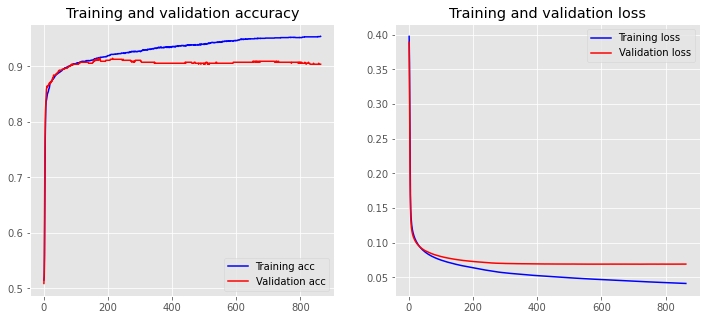

In [59]:
plot_history(history)

In [60]:
display_model_score(model,
    [X_train, y_train],
    [X_test, y_test],
    [X_test, y_test],
    256)

9/9 [==============================] - 0s 2ms/step - loss: 0.0412 - accuracy: 0.9542
Train loss:  0.04121777415275574
Train accuracy:  0.9541611075401306
----------------------------------------------------------------------
3/3 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.9039
Val loss:  0.06920407712459564
Val accuracy:  0.9039145708084106
----------------------------------------------------------------------
3/3 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.9039
Test loss:  0.06920407712459564
Test accuracy:  0.9039145708084106


### CNN

In [61]:
Y_train = np.reshape(y_train,(len(y_train),1)).astype(int)
Y_test = np.reshape(y_test,(len(y_test),1)).astype(int)

In [62]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dense
from keras.layers import Flatten

In [63]:
n_timesteps, n_features, n_outputs =X_train.shape[0], X_train.shape[1], Y_train.shape[1]

In [64]:
# Building the CNN Model
cnn_model = Sequential()      # initializing the Sequential nature for CNN model

In [65]:
cnn_model.add(Conv1D(filters=64, kernel_size=1, 
activation='relu',input_shape=(n_features,1)))
cnn_model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(250, activation='relu'))
cnn_model.add(Dense(n_outputs, activation='sigmoid'))

In [66]:
cnn_model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam (learning_rate=1e-3), 
                  metrics=['accuracy'])

In [67]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 82, 64)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 82, 64)            4160      
                                                                 
 conv1d_2 (Conv1D)           (None, 82, 64)            4160      
                                                                 
 dropout (Dropout)           (None, 82, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 41, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2624)              0         
                                                      

In [68]:
# fit network
history = cnn_model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=1000, batch_size=50, verbose=0)

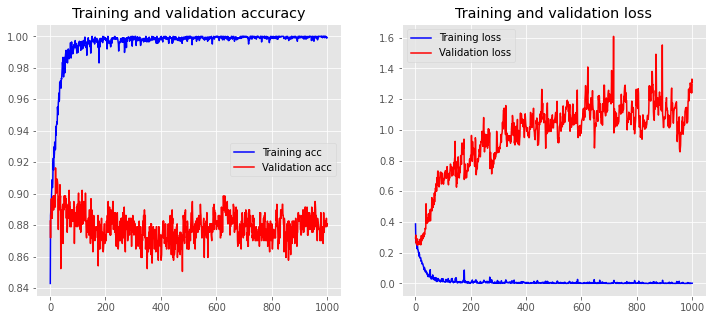

In [69]:
plot_history(history)

In [70]:
display_model_score(cnn_model,
    [X_train, Y_train],
    [X_test, Y_test],
    [X_test, Y_test],
    256)

9/9 [==============================] - 0s 10ms/step - loss: 4.4253e-05 - accuracy: 1.0000
Train loss:  4.4252799852984026e-05
Train accuracy:  1.0
----------------------------------------------------------------------
3/3 [==============================] - 0s 4ms/step - loss: 1.3131 - accuracy: 0.8808
Val loss:  1.3130707740783691
Val accuracy:  0.8807829022407532
----------------------------------------------------------------------
3/3 [==============================] - 0s 4ms/step - loss: 1.3131 - accuracy: 0.8808
Test loss:  1.3130707740783691
Test accuracy:  0.8807829022407532


In [71]:
y_pred = cnn_model.predict(X_test)

In [72]:
y_pred = np.reshape(y_pred,(len(y_pred),)).astype(int)

In [73]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84       281
           1       0.98      0.64      0.77       281

    accuracy                           0.81       562
   macro avg       0.86      0.81      0.81       562
weighted avg       0.86      0.81      0.81       562



### NN

In [74]:
modelx = Sequential([        
        Dense(len(X_train) , activation='relu', name='hidden_1', input_dim=82),
        Dropout(0.2),
        Dense(int(len(X_train) / 2), activation='relu', name='hidden_2'),
        Dropout(0.2),
        #Dense(int(len(X_train) / 2), activation='relu', name='hidden_3'),
        #Dropout(0.2),
        #Dense(int(len(X_train) / 2), activation='relu', name='hidden_4'),
        #Dropout(0.2),
        #Dense(int(len(train_pad) / 2), activation='tanh', name='hidden_5'),
        #Dropout(0.3),
        Dense(int(len(X_train) / 2), activation='relu', name='outer'),
        Dropout(0.2),
        Dense(1, activation='sigmoid'),
    ])
modelx.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 2247)              186501    
                                                                 
 dropout_1 (Dropout)         (None, 2247)              0         
                                                                 
 hidden_2 (Dense)            (None, 1123)              2524504   
                                                                 
 dropout_2 (Dropout)         (None, 1123)              0         
                                                                 
 outer (Dense)               (None, 1123)              1262252   
                                                                 
 dropout_3 (Dropout)         (None, 1123)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [75]:
modelx.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [76]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=150, verbose=1)

In [77]:
historyx = modelx.fit(
     X_train, y_train,
     epochs=100, batch_size=50,
     validation_data=(X_test, y_test),
     callbacks=[es]
     )

Epoch 1/100
45/45 [==============================] - 1s 8ms/step - loss: 0.3207 - accuracy: 0.8741 - val_loss: 0.2913 - val_accuracy: 0.8808
Epoch 2/100
45/45 [==============================] - 0s 4ms/step - loss: 0.2170 - accuracy: 0.9141 - val_loss: 0.2847 - val_accuracy: 0.8986
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 0.2004 - accuracy: 0.9186 - val_loss: 0.2783 - val_accuracy: 0.8879
Epoch 4/100
45/45 [==============================] - 0s 4ms/step - loss: 0.1828 - accuracy: 0.9310 - val_loss: 0.3200 - val_accuracy: 0.9075
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 0.1698 - accuracy: 0.9341 - val_loss: 0.2772 - val_accuracy: 0.9093
Epoch 6/100
45/45 [==============================] - 0s 4ms/step - loss: 0.1535 - accuracy: 0.9377 - val_loss: 0.2882 - val_accuracy: 0.8968
Epoch 7/100
45/45 [==============================] - 0s 4ms/step - loss: 0.1304 - accuracy: 0.9488 - val_loss: 0.3258 - val_accuracy: 0.9039
Epoch 8/100
4

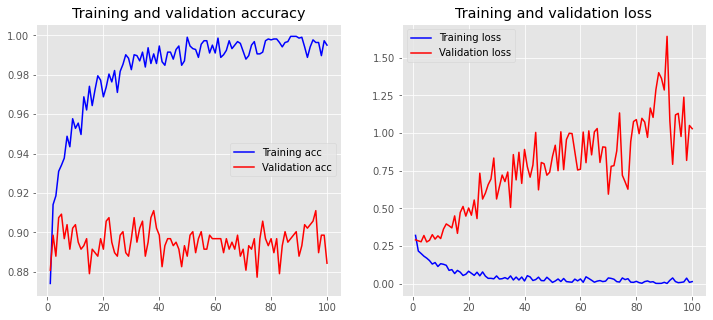

In [78]:
plot_history(historyx)

In [79]:
display_model_score(modelx,
    [X_train, y_train],
    [X_test, y_test],
    [X_test, y_test],
    256)

9/9 [==============================] - 0s 3ms/step - loss: 0.0114 - accuracy: 0.9969
Train loss:  0.0114479660987854
Train accuracy:  0.9968847632408142
----------------------------------------------------------------------
3/3 [==============================] - 0s 4ms/step - loss: 1.0290 - accuracy: 0.8843
Val loss:  1.0289853811264038
Val accuracy:  0.8843416571617126
----------------------------------------------------------------------
3/3 [==============================] - 0s 4ms/step - loss: 1.0290 - accuracy: 0.8843
Test loss:  1.0289853811264038
Test accuracy:  0.8843416571617126


In [80]:
y_pred = modelx.predict(X_test)

In [81]:
y_pred = np.reshape(y_pred,(len(y_pred),)).astype(int)

In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.99      0.84       281
           1       0.99      0.62      0.76       281

    accuracy                           0.80       562
   macro avg       0.85      0.80      0.80       562
weighted avg       0.85      0.80      0.80       562



### LSTM

In [163]:
x_input = Input(shape=(82,))
emb = Embedding(20, 64, input_length=82)(x_input)
bi_rnn = CuDNNLSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))(emb)
x = Dropout(0.3)(bi_rnn)

# sigmoid classifier
x_output = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=x_input, outputs=x_output)

In [164]:
model2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 82)]              0         
                                                                 
 embedding_20 (Embedding)    (None, 82, 64)            1280      
                                                                 
 cu_dnnlstm_14 (CuDNNLSTM)   (None, 64)                33280     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 34,625
Trainable params: 34,625
Non-trainable params: 0
_________________________________________________________________


In [165]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=150, verbose=1)

In [166]:
model2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

In [167]:
history2 = model2.fit(
     X_train, y_train,
     epochs=100, batch_size=256,
     validation_data=(X_test, y_test),
     callbacks=[es]
     )

Epoch 1/100
9/9 [==============================] - 2s 48ms/step - loss: 2.8386 - accuracy: 0.5194 - val_loss: 2.6553 - val_accuracy: 0.5036
Epoch 2/100
9/9 [==============================] - 0s 13ms/step - loss: 2.5278 - accuracy: 0.5234 - val_loss: 2.3748 - val_accuracy: 0.5214
Epoch 3/100
9/9 [==============================] - 0s 14ms/step - loss: 2.2681 - accuracy: 0.5630 - val_loss: 2.1416 - val_accuracy: 0.5694
Epoch 4/100
9/9 [==============================] - 0s 14ms/step - loss: 2.0539 - accuracy: 0.6075 - val_loss: 1.9502 - val_accuracy: 0.6032
Epoch 5/100
9/9 [==============================] - 0s 13ms/step - loss: 1.8777 - accuracy: 0.6061 - val_loss: 1.7925 - val_accuracy: 0.6014
Epoch 6/100
9/9 [==============================] - 0s 13ms/step - loss: 1.7298 - accuracy: 0.6404 - val_loss: 1.6561 - val_accuracy: 0.6530
Epoch 7/100
9/9 [==============================] - 0s 13ms/step - loss: 1.6043 - accuracy: 0.6395 - val_loss: 1.5475 - val_accuracy: 0.6459
Epoch 8/100
9/9 [===

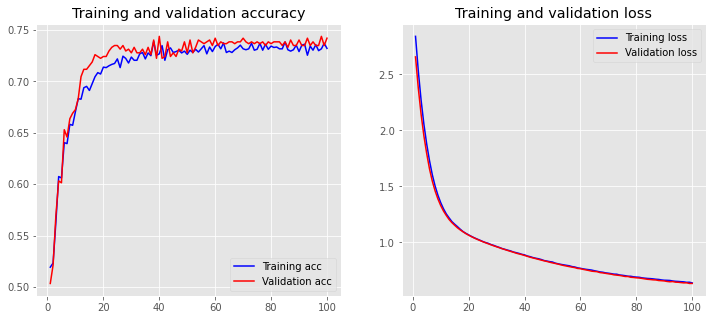

In [168]:
plot_history(history2)

In [169]:
display_model_score(model2,
    [X_train, y_train],
    [X_test, y_test],
    [X_test, y_test],
    256)

9/9 [==============================] - 0s 5ms/step - loss: 0.6363 - accuracy: 0.7339
Train loss:  0.6363393664360046
Train accuracy:  0.7338674068450928
----------------------------------------------------------------------
3/3 [==============================] - 0s 5ms/step - loss: 0.6342 - accuracy: 0.7420
Val loss:  0.6342224478721619
Val accuracy:  0.7419928908348083
----------------------------------------------------------------------
3/3 [==============================] - 0s 5ms/step - loss: 0.6342 - accuracy: 0.7420
Test loss:  0.6342224478721619
Test accuracy:  0.7419928908348083


In [170]:
y_pred = model2.predict(X_test)

In [171]:
y_pred = np.reshape(y_pred,(len(y_pred),)).astype(int)

In [172]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       281
           1       0.00      0.00      0.00       281

    accuracy                           0.50       562
   macro avg       0.25      0.50      0.33       562
weighted avg       0.25      0.50      0.33       562



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### BLSTM

In [152]:
X_train.shape

(2247, 82)

In [153]:
x_input = Input(shape=(82,))
emb = Embedding(20, 64, input_length=82)(x_input)
bi_rnn = Bidirectional(CuDNNLSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# sigmoid classifier
x_output = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=x_input, outputs=x_output)

In [154]:
model2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 82)]              0         
                                                                 
 embedding_19 (Embedding)    (None, 82, 64)            1280      
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              66560     
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 67,969
Trainable params: 67,969
Non-trainable params: 0
_______________________________________________________

In [155]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=150, verbose=1)

In [156]:
model2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

In [157]:
history = model2.fit(
     X_train, y_train,
     epochs=1000, batch_size=512,
     validation_data=(X_test, y_test),
     callbacks=[es]
     )

Epoch 1/1000
5/5 [==============================] - 3s 151ms/step - loss: 5.1457 - accuracy: 0.5189 - val_loss: 4.8984 - val_accuracy: 0.5000
Epoch 2/1000
5/5 [==============================] - 0s 25ms/step - loss: 4.7743 - accuracy: 0.5176 - val_loss: 4.5490 - val_accuracy: 0.5000
Epoch 3/1000
5/5 [==============================] - 0s 25ms/step - loss: 4.4351 - accuracy: 0.5296 - val_loss: 4.2317 - val_accuracy: 0.5338
Epoch 4/1000
5/5 [==============================] - 0s 26ms/step - loss: 4.1300 - accuracy: 0.5719 - val_loss: 3.9460 - val_accuracy: 0.5730
Epoch 5/1000
5/5 [==============================] - 0s 27ms/step - loss: 3.8539 - accuracy: 0.5759 - val_loss: 3.6902 - val_accuracy: 0.5463
Epoch 6/1000
5/5 [==============================] - 0s 26ms/step - loss: 3.6073 - accuracy: 0.5772 - val_loss: 3.4605 - val_accuracy: 0.5747
Epoch 7/1000
5/5 [==============================] - 0s 25ms/step - loss: 3.3860 - accuracy: 0.5888 - val_loss: 3.2561 - val_accuracy: 0.5712
Epoch 8/1000

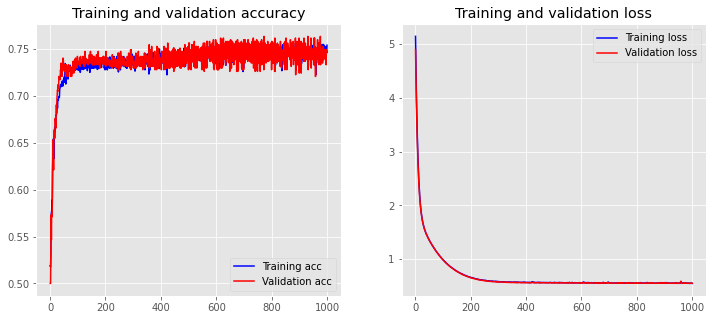

In [158]:
plot_history(history)

In [159]:
display_model_score(model2,
    [X_train, y_train],
    [X_test, y_test],
    [X_test, y_test],
    256)

9/9 [==============================] - 0s 7ms/step - loss: 0.5476 - accuracy: 0.7526
Train loss:  0.5475670695304871
Train accuracy:  0.7525589466094971
----------------------------------------------------------------------
3/3 [==============================] - 0s 7ms/step - loss: 0.5507 - accuracy: 0.7473
Val loss:  0.5506591200828552
Val accuracy:  0.7473309636116028
----------------------------------------------------------------------
3/3 [==============================] - 0s 7ms/step - loss: 0.5507 - accuracy: 0.7473
Test loss:  0.5506591200828552
Test accuracy:  0.7473309636116028


In [160]:
y_pred = model2.predict(X_test)

In [161]:
y_pred = np.reshape(y_pred,(len(y_pred),)).astype(int)

In [162]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       281
           1       0.00      0.00      0.00       281

    accuracy                           0.50       562
   macro avg       0.25      0.50      0.33       562
weighted avg       0.25      0.50      0.33       562



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
